# works does hourly not overall model

In [157]:
# arima forecast for the power usage dataset
import pandas as pd
import numpy as np

from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import psutil
import ast

## Loading in and structuring data

In [158]:
# load in data and visualise
dataset = pd.read_csv('wb_47_for_arima.csv', parse_dates=True, index_col = 'time', header=0)
# Limit datast so it only includes complete 24 hour periods
dataset = dataset.iloc[9:489, 1]
dataset

time
2019-06-12 00:00:00+03:00    105.107209
2019-06-12 01:00:00+03:00    131.277045
2019-06-12 02:00:00+03:00    146.717045
2019-06-12 03:00:00+03:00    159.313023
2019-06-12 04:00:00+03:00    152.174091
                                ...    
2019-07-01 19:00:00+03:00     28.967500
2019-07-01 20:00:00+03:00     28.752667
2019-07-01 21:00:00+03:00     35.578182
2019-07-01 22:00:00+03:00     44.091818
2019-07-01 23:00:00+03:00     45.789773
Name: pm_2_5, Length: 480, dtype: float64

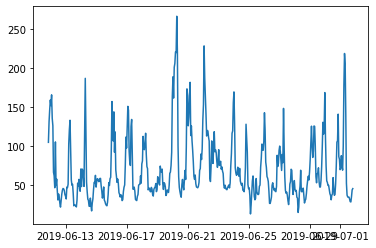

In [159]:
# simple plot of the dataset over three weeks
plt.plot(dataset)

In [160]:
# limit dataset to values only and save as an array
dataset = dataset.values

In [161]:
dataset

array([105.1072093 , 131.27704545, 146.71704545, 159.31302326,
       152.17409091, 165.95909091, 135.90116279, 126.35      ,
        66.82093023,  62.26395349,  46.91931818, 105.61883721,
        50.69090909,  58.02906977,  42.74431818,  31.20681818,
        38.89545455,  34.92422222,  26.96727273,  22.09866667,
        29.856     ,  38.5272093 ,  43.67568182,  45.99116279,
        45.41340909,  43.36840909,  38.09772727,  35.96840909,
        32.53466667,  47.69534884,  47.06418605,  51.46590909,
       103.1472093 , 121.66363636, 133.40045455,  93.74232558,
        56.98697674,  50.21704545,  51.32772727,  39.87681818,
        23.77288889,  25.02977778,  24.70911111,  23.71311111,
        22.35688889,  31.13704545,  52.69674419,  48.80233333,
        57.61666667,  45.18257143,  42.40372093,  70.92772727,
        48.41395349,  70.87488372,  69.50488372,  58.72727273,
        48.65232558, 120.79906977, 187.1247619 , 125.72069767,
        54.24880952,  41.9275    ,  32.28681818,  30.61

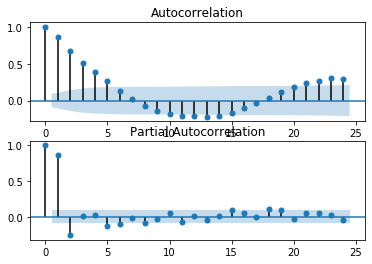

In [162]:
# Generate ACF and PCF charts

# convert training data into a series
series = dataset
# plots specifying number of lags to includ
plt.figure()
lags = 24
# acf
axis = plt.subplot(2, 1, 1)
plot_acf(series, ax=axis, lags=lags)
# pacf
axis = plt.subplot(2, 1, 2)
plot_pacf(series, ax=axis, lags=lags)
# show plot
plt.show()

It appears that autocorrelation values of 6 or 7 are reasonable although around 10-15 and 23 plus are also potentially valid

In [163]:
dataset.shape

(480,)

Create a list of models to be tested
Split the datset into train and test leaving 24 hours out of sample
split the train and test set into 19 lists represetning days each containing a list of 24 hours,

Evaluate the models on the train and test set





Generate 
    score - 
    scores - 


Split the datset into train and test leaving 24 hours out of sample
split the train and test set into 19 lists represetning days each containing a list of 24 hours,

In [164]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[0:-192], data[-192:-24]
    final_test = data[-24:]
    # restructure into windows of weekly data
    train = array(split(train, (len(train)/24)))
    test = array(split(test, (len(test)/24)))
    return train, test, final_test

In [165]:
# Generating train and test
train, test = split_dataset(dataset)[0:2]

In [166]:
final_test = split_dataset(dataset)[2]
print('final test', final_test)
print('final test shape',final_test.shape)

final test [141.21431818  86.77255814  83.38372093  70.07931818  71.70674419
  88.01860465  75.67651163  69.44       100.31931818 177.3644186
 218.97888889 205.83318182 140.97        52.6         37.45
  35.20111111  34.62477273  34.9375      32.36644444  28.9675
  28.75266667  35.57818182  44.09181818  45.78977273]
final test shape (24,)


In [167]:
#Checking the size of the train and test sets
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (12, 24)
test shape:  (7, 24)


Create a list of models to be tested

In [168]:
train.shape

(12, 24)

Evauate the actual and predicted ie the test set and the predicted set
For each of the 24 column in the train set
calculate the rmse for the actual and predicted, this will be hour by hour
add the score to the scores list which is a list of rmses for each hour

for each day
For each row, for each column calculate the rmse of the pairs
square and add the total to the list
Once complete calculate score by dividing s by the size of the test set




In [169]:
# convert windows of weekly multivariate data into a series of total power
def to_series(data):
    # extract just the total power from each week
    series = [day for day in data]
    # flatten into a single series
    series = array(series).flatten()
    print('series.shape: ', series.shape)
    return series

In [187]:
# sarima forecast
# Takes the history (train set plus day by day testing) and configuration
# converts history values to a single long series
# generates the sarima model based on config parameters
# fits the sarima model to the series data
# creates yhat, a prediction of the next 24 hours int he test set
def sarima_forecast(history, config):
    order, sorder, trend = config
    print('order', order)
    print('sorder', sorder)
    print('trand', trend)
    # convert history into a univariate series
    series = to_series(history)
#     series = to_series(history)
#     print('series', series)
    # define model
    model = SARIMAX(series, order=order, seasonal_order=sorder, trend = trend,enforce_stationarity=False, enforce_invertibility=False)
#     model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    print('model', model)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(series), len(series)+23)
#     print('yhat', yhat)
#     print('yhat 0', yhat[0])
    return yhat

In [188]:
# evaluate a single model which creates a prediction for ech day and each hour
# This is then fed into the evaluate forecast function to generate overall scores for the model
# for the model
# This needs to happen for every incarnation of the model
def evaluate_model(model_func, train, test, config):
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
##        config = ((2,0,6), (1,0,1,24), 'n')
        yhat_sequence = model_func(history, config)
#         yhat_sequence = sarima_fore(history, config)
#         print('history', history)
#         print('yhat_sequence', yhat_sequence)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        print('test[i,:]',test[i,:])
        history.append(test[i, :])
#         print('predictions', predictions)
#         print('history', history)
    predictions = array(predictions)
#     print('len(predictions)', len(predictions))
    print('predictions.shape', predictions.shape)
    # evaluate predictions days for each week
#     score, scores = evaluate_forecasts(test, predictions)
    score, scores = evaluate_forecasts(test, predictions)
    print('score', score)
#     print('scores', scores)
#     return score, scores
    return score, scores

In [189]:
# evaluate forecasts for all hours across all days
# takes all the actual and predicted values gained through the test set
# For each of the 24 columns, take the rmse of the column in actual and predicted
# add the rmse for each hour in each day to 'SCORES' a list of 24 rmse

# Then compare the differnce betwen individual for each row (day) and each column (hour) in the actual and predicted. 
# Square them, sum them and divide by the number of cells to give and average rmse
# This is SCORE
# Return SCORE and scores

def evaluate_forecasts(actual, predicted):
    print('actual.shape : ', actual.shape)
#     print('predicted.shape', predicted.shape)
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        print('i', i)
#         print('actual.shape : ', actual.shape)
#         print('predicted.shape', predicted.shape)
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        print('mse', mse)
        # calculate rmse
        rmse = sqrt(mse)
        print('rmse', rmse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
#     return score, scores
    return score, scores

In [190]:
# summarize scores
#Takes the name, model score and list of hourley mean scores
#print
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f]' % (name, score))

In [191]:
# create a set of sarima configs to try
def sarima_configs(seasonal=[24]):
    models = list()
    # define config lists
    p_params = [0]
    d_params = [0]
    q_params = [0,6]
#     t_params = ['n','c','t','ct']
    t_params = ['c']
    P_params = [0]
    D_params = [0]
    Q_params = [0]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [192]:
# grid search configs
# Using train, test data and the list of configurations
# working in parallel


# def grid_search(data, cfg_list, n_test, parallel=True):
def grid_search(model_func, train, test, cfg_list, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=psutil.cpu_count(), verbose=1)
        tasks = (delayed(score_model)(model_func,train, test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(model_func,train, test, cfg) for cfg in cfg_list]
    # remove empty results
    print(scores)
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

In [193]:
# score a model, return None on failure

def score_model(model_func,train, test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
#         result = walk_forward_validation(data, n_test, cfg)
        result = evaluate_model(model_func,train, test, cfg)[0]
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = evaluate_model(model_func,train, test, cfg)[0]
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

The summary of the scores takes the name of the mode, the overall score in square brackets and a list of each of the 24 hourly socres

For each model using the train and test set
take each of the 12 X 24 hours lists and read them into 'history'
generate an empty list (predictions)
apply the model to history to generate a sequence of predictions called yhat - this will be.....
add that sequence to the predictions list
add the firsts and subsequent days data to the list of histories
Once all forecasts have been made and history comprises the whole training and test set
Evaluate the result based on the test set and the predictions made
return score and scores

take a list of data known as history, in this case it is a list of lists for each day

Define models to be trained

In [194]:

# define the names and functions for the models we wish to evaluate
models = dict()
models['sarima'] = sarima_forecast

# name each hour to be aggregated
hours = ['0', '1', '2', '3', '4', '5', '6', '7', '8','9','10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']


In [195]:
# # walk-forward validation for univariate data
# def walk_forward_validation(data, n_test, cfg):
#     predictions = list()
#     # split dataset
#     train, test = train_test_split(data, n_test)
#     # seed history with training dataset
#     history = [x for x in train]
#     # step over each time-step in the test set
#     for i in range(len(test)):
#         # fit model and make forecast for history
#         yhat = sarima_forecast(history, cfg)
#         # store forecast in list of predictions
#         predictions.append(yhat)
#         # add actual observation to history for the next loop
#         history.append(test[i])
#     print(len(history))
#     # estimate prediction error
#     error = measure_rmse(test, predictions)
#     return error

In [196]:
# data split
n_test = 24
# model configs
cfg_list = sarima_configs(seasonal=[24])
# print(cfg_list)

In [197]:
# grid search
scores = grid_search(sarima_forecast, train, test, cfg_list)
print('done')
# list top 3 configs
for cfg, error in scores[:10]:
    print(cfg, error)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[("[(0, 0, 0), (0, 0, 0, 24), 'c']", 32.290097761759945), ("[(0, 0, 6), (0, 0, 0, 24), 'c']", 31.347523465049917)]
done
[(0, 0, 6), (0, 0, 0, 24), 'c'] 31.347523465049917
[(0, 0, 0), (0, 0, 0, 24), 'c'] 32.290097761759945


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.7s finished


[(0, 0, 6), (0, 0, 0, 24), 'c'] 31.347523465049917

[(2, 0, 6), (0, 0, 0, 24), 'c'] 31.69938239798541

[(0, 0, 0), (0, 0, 0, 24), 'c'] 32.290097761759945

## PREDICTING THE NEXT 24 HOURS OUT OF SAMPLE

In [198]:
# best_config = scores[:1]
best_config = ast.literal_eval(scores[:1][0][0])

In [199]:
best_config

[(0, 0, 6), (0, 0, 0, 24), 'c']

In [200]:
best_oos_yhat = sarima_forecast(dataset, best_config)

order (0, 0, 6)
sorder (0, 0, 0, 24)
trand c
series.shape:  (480,)
model <statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x0000027285B795F8>


In [201]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [202]:
oos_rmse = measure_rmse(final_test, best_oos_yhat)
oos_rmse

57.73883592029966

In [ ]:
Don't run  this its fine

In [ ]:
# For each model named (only SARIMA here)
# Extract the name and the function - for a single config
# Run the model across the whole test set
# generte the score and scores
# plot the hourly scores
for name, func in models.items():
    # evaluate and get scores
    for config in cfg_list:
        score, scores = evaluate_model(func, train, test, config)
    # summarize scores
        summarize_scores(name, score, scores)

#     # plot scores
#     plt.plot(hours, scores, marker='o', label=name)
# # show plot
# plt.legend()
# plt.show()

In [ ]:
# show plot
# plot scores
plt.plot(hours, scores, marker='o', label=name)
plt.legend()
plt.show()

In [ ]:
scores